# Neural Network using PyTorch

In this exercise, you will build a neural network using PyTorch, and apply it to a dataset. Our goal in this exercise is not necessarily to obtain the best results on the dataset. We care more about understanding the different parameters, getting a hands-on experience training networks, and monitoring and debugging them. For this reason, I actually recommend that you don’t use a GPU, and run the code on your local machine, for simpler debugging.


You can get relevant code snippets from [the PyTorch documentation](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) or other sources online. 

## Dataset
We will use the CIFAR-10 dataset.

In [16]:
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
%matplotlib inline

In [17]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


First, let's get to know the dataset. Plot a few examples of images and their labels:


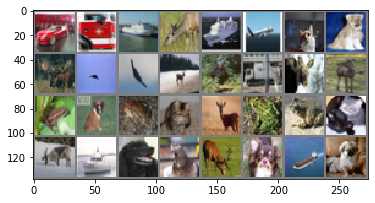

car   truck   ship   deer


In [49]:
import matplotlib.pyplot as plt
import numpy as np


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('   '.join(classes[labels[j]] for j in range(4)))

Display the distribution of images per label.

In [50]:
temp = np.array(trainset.targets)
unique, counts = np.unique(temp, return_counts=True)
dict(zip(classes, counts))

{'plane': 5000,
 'car': 5000,
 'bird': 5000,
 'cat': 5000,
 'deer': 5000,
 'dog': 5000,
 'frog': 5000,
 'horse': 5000,
 'ship': 5000,
 'truck': 5000}

Is the data balanced? What effect is imbalanced data expected to have on your model's results? How can you work with imbalanced data?

Yes. 

It's prone to biaseness towards the prevalent class and overfitting training data.

**NOTE:** It's a good practice when working on Neural Networks to start with a very small dataset and overfit on it. While we don't specifically ask you to do so in the sections below, we recommend that you take this approach, and first write and run your code using easy to use and debug platform, on a small dataset.

## Build your own CNN classifier - Maria?
In this section, you will develop your own CNN classifier.

This is meant as an opportunity to get more experience building your own NN architectures using PyTorch, and our focus is on making sure you rewrite and review the needed code and not on obtaining optimal performance. That being said, within the limits of the time you have, try to come up with a NN architecture and hyperparameters that would achieve nice results on the dataset.  
We do recommend that you keep this to only 3-4 Conv layers and 1-2 fully connected layers.

If you want a starting point, you can create this network:

```
Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
```

When training the network, use the Adam optimizer.

In [59]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.fc1 = nn.Linear(400, 120, bias=True)
        self.fc2 = nn.Linear(120, 10, bias=True)
        # Loss function.
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, X):
        X = self.pool(F.relu(self.conv1(X)))
        X = self.pool1(F.relu(self.conv2(X)))
        X = X.view(-1, 400)
        X = F.relu(self.fc1(X))
        return self.fc2(X)
    
    def loss(self, y_pred, y_true):
        return self.criterion(y_pred, y_true)
    
    def trainWithLoader(self, trainloader, epochs=2, lr=0.001, print_stats=True):
        self.train()
        optimizer = optim.Adam(self.parameters(), lr=lr)
        for epoch in range(epochs):
            running_loss = 0.0
            for i, data in enumerate(trainloader, 0):
                optimizer.zero_grad()
                X, y_true = data

                y_pred = self.forward(X)
                loss = self.loss(y_pred, y_true)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                if print_stats and i % 2000 == 0 and i != 0:
                    print('[%d, %5d] loss: %.3f' % (epoch + 1, i, running_loss / 2000))
                    running_loss = 0.0
        print('Finished Training')
    
    def evaluate(self, testloader):
        self.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in testloader:
                X, y_true = data
                y_pred = self(X)
                _, predicted = torch.max(y_pred.data, 1)
                total += y_true.size(0)
                correct += (predicted == y_true).sum().item()
        return correct / total



net = Net()

## Tensorboard
TensorBoard provides visualization and tooling for machine learning experimentation:
- Tracking and visualizing metrics such as loss and accuracy
- Visualizing the model graph (ops and layers)
- Viewing histograms of weights, biases, or other tensors as they change over time
- Projecting embeddings to a lower dimensional space
- Displaying images, text, and audio data
- Profiling programs

Tensorboard worked originally with Tensorflow but can now be used with PyTorch as well.  
You can embed a tensorboard widget in a Jupyter Notebook, although if you're not using Google Colab we recommend that you open tensorboard separately.

To get started with Tensorboard, please read the following pages:

PyTorch related:
1. https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html
1. https://becominghuman.ai/logging-in-tensorboard-with-pytorch-or-any-other-library-c549163dee9e
1. https://towardsdatascience.com/https-medium-com-dinber19-take-a-deeper-look-at-your-pytorch-model-with-the-new-tensorboard-built-in-513969cf6a72
1. https://pytorch.org/docs/stable/tensorboard.html
1. https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/04-utils/tensorboard

Tensorflow related:
1. https://itnext.io/how-to-use-tensorboard-5d82f8654496
1. https://www.datacamp.com/community/tutorials/tensorboard-tutorial
1. https://medium.com/@anthony_sarkis/tensorboard-quick-start-in-5-minutes-e3ec69f673af
1. https://www.guru99.com/tensorboard-tutorial.html
1. https://www.youtube.com/watch?time_continue=1&v=s-lHP8v9qzY&feature=emb_logo
1. https://www.youtube.com/watch?v=pSexXMdruFM


### Starting Tensorboard
Jupyter Notebook has extensions for displaying TensorBoard inside the notebook. Still, I recommend that you run it separately, as it tends to get stuck in notebooks.

The syntax to load TensorBoard in a notebook is this:
```python
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir ./logs
```

In the shell, you can instead run:
```
tensorboard --logdir ./logs
```

In [52]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('logs')

### Show images using TensorBoard

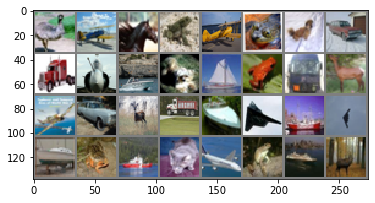

In [53]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
imshow(img_grid)

# write to tensorboard
writer.add_image('img_grid', img_grid)
writer.flush()

### Inspect the model graph
You can print a network object to find useful information about it:

In [62]:
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
  (criterion): CrossEntropyLoss()
)


TensorBoard can help visualize the network graph. It takes practice to read these.  

Write the graph to TensorBoard and review it.

In [63]:
writer.add_graph(net, images)
writer.flush()

You can also use the package `torchsummary` for a fuller info on the model:

In [56]:
!pip install torchsummary

In [57]:
channels=3; H=32; W=32
from torchsummary import summary
summary(net, input_size=(channels, H, W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 10]           1,210
Total params: 52,202
Trainable params: 52,202
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.20
Estimated Total Size (MB): 0.27
----------------------------------------------------------------


## Train the network
Next, we'll train the network. In the training loop, log relevant metrics that would allow you to plot in TensorBoard:

1. The network loss
1. Train and test error
1. Average weight in the first layer - TODO
1. Histogram of weights in the first layer - TODO

In [60]:
net.trainWithLoader(trainloader)

print('Accuracy of the network on the train data: %.2f' % net.evaluate(trainloader))
print('Accuracy of the network on the test data: %.2f' % net.evaluate(testloader))

Finished Training
Accuracy of the network on the train data: 0.59
Accuracy of the network on the test data: 0.58


### Precision-Recall Curve
Use TensorBoard to plot the precision-recall curve:

In [17]:
# 1. gets the probability predictions in a test_size x num_classes Tensor
# 2. gets the preds in a test_size Tensor

class_probs = []
class_preds = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        output = net(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]
        _, class_preds_batch = torch.max(output, 1)

        class_probs.append(class_probs_batch)
        class_preds.append(class_preds_batch)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_preds = torch.cat(class_preds)

def add_pr_curve_tensorboard(class_index, test_probs, test_preds):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_preds = test_preds == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_preds,
                        tensorboard_probs)
    writer.flush()

# plot all the pr curves
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_preds)

writer.close()

### Display Model Errors
A valuable practice is to review errors made by the model in the test set. These might reveal cases of bad preprocessing or lead to come up with improvements to your original model.

Show 12 images of errors made by the model. For each, display the true and predicted classes, and the model confidence in its answer.

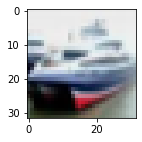

True class - "ship", predicted "car", confidence 0.83



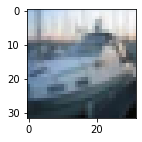

True class - "ship", predicted "truck", confidence 0.41



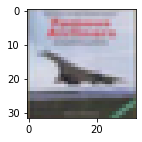

True class - "plane", predicted "ship", confidence 0.48



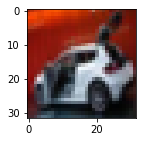

True class - "car", predicted "truck", confidence 0.52



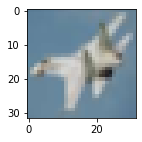

True class - "plane", predicted "deer", confidence 0.55



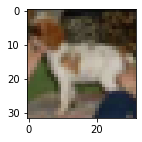

True class - "dog", predicted "cat", confidence 0.38



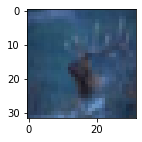

True class - "deer", predicted "bird", confidence 0.49



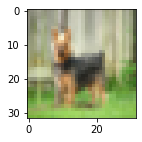

True class - "dog", predicted "deer", confidence 0.63



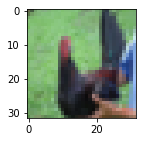

True class - "bird", predicted "frog", confidence 0.24



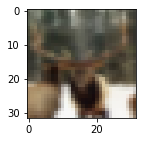

True class - "deer", predicted "dog", confidence 0.20



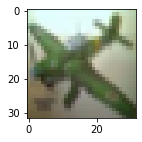

True class - "plane", predicted "horse", confidence 0.32



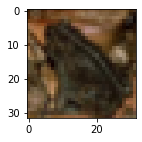

True class - "frog", predicted "cat", confidence 0.33



In [18]:
displayed = 12
true_targets = torch.IntTensor(testset.targets)
misclassified = np.where(test_preds != true_targets)[0][:displayed]

for i in misclassified:
    plt.figure(figsize = (2,2))
    plt.imshow(testset.data[i], interpolation='nearest')
    plt.show()
    true_class = classes[testset.targets[i]]
    pred_class = classes[test_preds[i].numpy()]
    print('True class - "%s", predicted "%s", confidence %.2f\n' % (true_class, pred_class, test_probs[i].max().numpy()))

It looks like the model bases its predicition on the prevalent color - if it's green then it predicts "deer", if it's blue then it predicts "plane".

## Batch Normalization - Avshalom?
In this section, we'll add a Batch Norm layer to your network.  
Use TensorBoard to compare the network's convergence (train and validation loss) with and without Batch Normalization.

In [214]:
from datetime import datetime

class NetBN(nn.Module):
    def __init__(self, fc_dims=400, padding=0, use_batch_norm=True, create_writer=False):
        super(NetBN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=padding)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.conv1_bn = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
        self.conv2_bn = nn.BatchNorm2d(16)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.fc1 = nn.Linear(fc_dims, 120, bias=True)
        self.fc1_bn = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 10, bias=True)
        # Loss function.
        self.criterion = nn.CrossEntropyLoss()
        self.BN = use_batch_norm
        self.fc_dims = fc_dims
        if create_writer:
            now = datetime.now()
            writer = SummaryWriter('logs/' + now.strftime("%Y%m%d-%H%M%S") + "/")
            self.writer = writer

    def forward(self, X, epoch=None):
        X = self.conv1(X)
#         print(X.shape)
        if self.BN:
            X = self.conv1_bn(X)
        X = F.relu(X)
        if epoch and self.writer:
            self.writer.add_histogram('conv1_acc', X + epoch, epoch)
        X = self.pool1(X)
        X = self.conv2(X)
        if self.BN:
            X = self.conv2_bn(X)
        X = F.relu(X)
        if epoch and self.writer:
            self.writer.add_histogram('conv2_acc', X + epoch, epoch)
        X = self.pool2(X)
#         print(X.shape)
        X = X.view(-1, self.fc_dims)
        X = self.fc1(X)
        if self.BN:
            X = self.fc1_bn(X)
        X = F.relu(X)
        if epoch and self.writer:
            self.writer.add_histogram('fc1_acc', X + epoch, epoch)
        return self.fc2(X)
    
    def loss(self, y_pred, y_true):
        return self.criterion(y_pred, y_true)
    
    def trainWithLoader(self, trainloader, epochs=4, lr=0.001, print_stats_ival=250, testloader=None):
        optimizer = optim.Adam(self.parameters(), lr=lr)
        for epoch in range(epochs):
            self.train()
            running_loss = 0.0
            for i, data in enumerate(trainloader, 0):
                print_stats_this_iteration = print_stats_ival and i % print_stats_ival == 0
                optimizer.zero_grad()
                X, y_true = data
                y_pred = self.forward(X, epoch if print_stats_this_iteration else None)
                loss = self.loss(y_pred, y_true)
                loss.backward()
                optimizer.step()
                
                if print_stats_this_iteration:
                    print('[%d, %5d] loss: %.3f' % (epoch + 1, i, loss.item()))
                    if self.writer:
                        self.writer.add_scalar('Train/Loss', loss.item(), epoch)
                    running_loss = 0.0    
            if testloader:
                test_loss, test_acc = self.evaluate(testloader)
                print('[{}] test loss, accuracy: {}, {}'.format(epoch + 1, test_loss, test_acc))
                if self.writer:
                    self.writer.add_scalar('Test/Loss', test_loss, epoch)
                    self.writer.add_scalar('Test/Accuracy', test_acc, epoch)
            if self.writer:
                self.writer.flush()
        if self.writer:
            self.writer.close()
        print('Finished Training')
    
    def evaluate(self, testloader):
        self.eval()
        correct = 0
        total = 0
        avg_loss = []
        with torch.no_grad():
            for data in testloader:
                X, y_true = data
                y_pred = self(X)
                loss = self.loss(y_pred, y_true)
                avg_loss.append(loss.item())
#                 print(avg_loss)
                _, predicted = torch.max(y_pred.data, 1)
                total += y_true.size(0)
                correct += (predicted == y_true).sum().item()
        return np.mean(avg_loss), correct / total





In [184]:
netBN = NetBN(create_writer=True, use_batch_norm=True)
netBN.trainWithLoader(trainloader, testloader=testloader, epochs = 5)
print('Loss, Accuracy of the network on the train data: {}'.format(netBN.evaluate(trainloader)))
print('Loss, Accuracy of the network on the test data: {}'.format(netBN.evaluate(testloader)))

[1,     0] loss: 2.421
[1,   250] loss: 1.562
[1,   500] loss: 1.533
[1,   750] loss: 1.440
[1,  1000] loss: 1.466
[1,  1250] loss: 1.374
[1,  1500] loss: 1.201
[1] test loss, accuracy: 1.232806766566377, 0.5654
[2,     0] loss: 1.154
[2,   250] loss: 1.260
[2,   500] loss: 0.972
[2,   750] loss: 1.351
[2,  1000] loss: 1.075
[2,  1250] loss: 0.941
[2,  1500] loss: 1.108
[2] test loss, accuracy: 1.0843374426372516, 0.6118
[3,     0] loss: 0.895
[3,   250] loss: 0.980
[3,   500] loss: 1.059
[3,   750] loss: 1.152
[3,  1000] loss: 0.921
[3,  1250] loss: 1.197
[3,  1500] loss: 0.831
[3] test loss, accuracy: 1.0196608748679725, 0.6387
[4,     0] loss: 0.780
[4,   250] loss: 1.114
[4,   500] loss: 0.968
[4,   750] loss: 0.795
[4,  1000] loss: 0.990
[4,  1250] loss: 1.063
[4,  1500] loss: 0.886
[4] test loss, accuracy: 0.9839611619044417, 0.6566
[5,     0] loss: 0.651
[5,   250] loss: 0.656
[5,   500] loss: 0.919
[5,   750] loss: 1.270
[5,  1000] loss: 1.125
[5,  1250] loss: 1.312
[5,  1500] 

Use TensorBoard to plot the distribution of activations with and without Batch Normalization.

In [108]:
netNoBN = NetBN(create_writer=True, use_batch_norm=False)
netNoBN.trainWithLoader(trainloader, testloader=testloader, epochs = 5)
print('Loss, Accuracy of the network on the train data: {}'.format(netNoBN.evaluate(trainloader)))
print('Loss, Accuracy of the network on the test data: {}'.format(netNoBN.evaluate(testloader)))

[1,     0] loss: 2.307
[1,   250] loss: 1.910
[1,   500] loss: 1.486
[1,   750] loss: 1.591
[1,  1000] loss: 1.266
[1,  1250] loss: 1.428
[1,  1500] loss: 1.238
[1] test loss, accuracy: 1.368585313040018, 0.5105
[2,     0] loss: 1.143
[2,   250] loss: 1.276
[2,   500] loss: 1.617
[2,   750] loss: 1.380
[2,  1000] loss: 1.590
[2,  1250] loss: 1.170
[2,  1500] loss: 1.466
[2] test loss, accuracy: 1.2574884571015834, 0.552
[3,     0] loss: 1.342
[3,   250] loss: 1.138
[3,   500] loss: 1.365
[3,   750] loss: 1.207
[3,  1000] loss: 1.027
[3,  1250] loss: 1.226
[3,  1500] loss: 0.882
[3] test loss, accuracy: 1.1505339010030031, 0.5875
[4,     0] loss: 1.091
[4,   250] loss: 0.758
[4,   500] loss: 1.030
[4,   750] loss: 1.058
[4,  1000] loss: 0.997
[4,  1250] loss: 1.064
[4,  1500] loss: 1.066
[4] test loss, accuracy: 1.173022831338644, 0.5866
[5,     0] loss: 0.616
[5,   250] loss: 1.127
[5,   500] loss: 0.775
[5,   750] loss: 0.923
[5,  1000] loss: 1.103
[5,  1250] loss: 0.904
[5,  1500] lo

(In all screenshots, Grey color is without BatchNorm).

We see that batch norm gives a significant improvement of ~0.035 percents improvement on validation set.
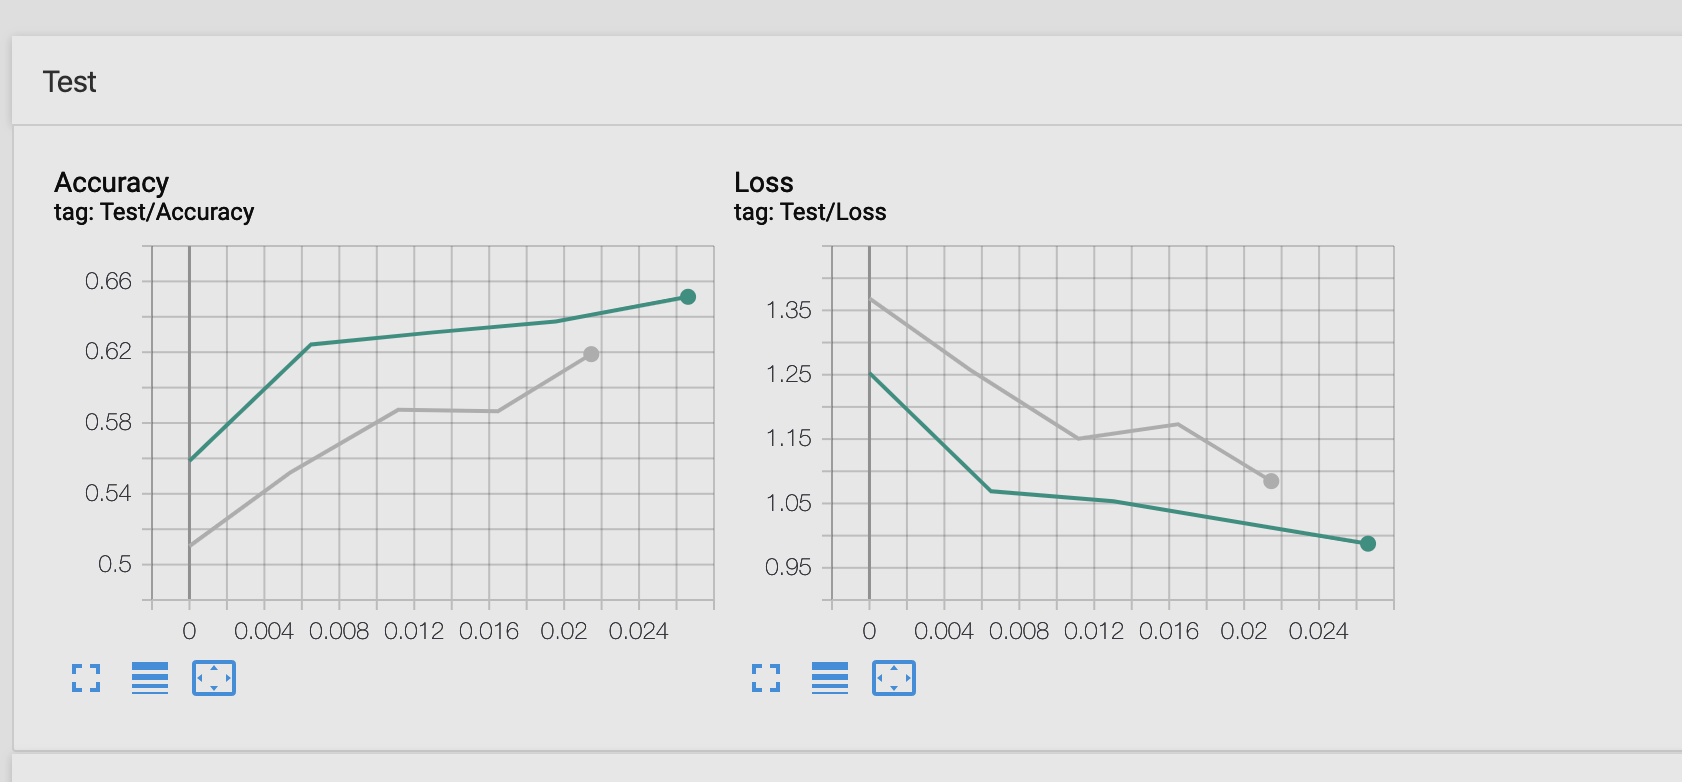


Compare activations of first layer (Grey is without BatchNorm):

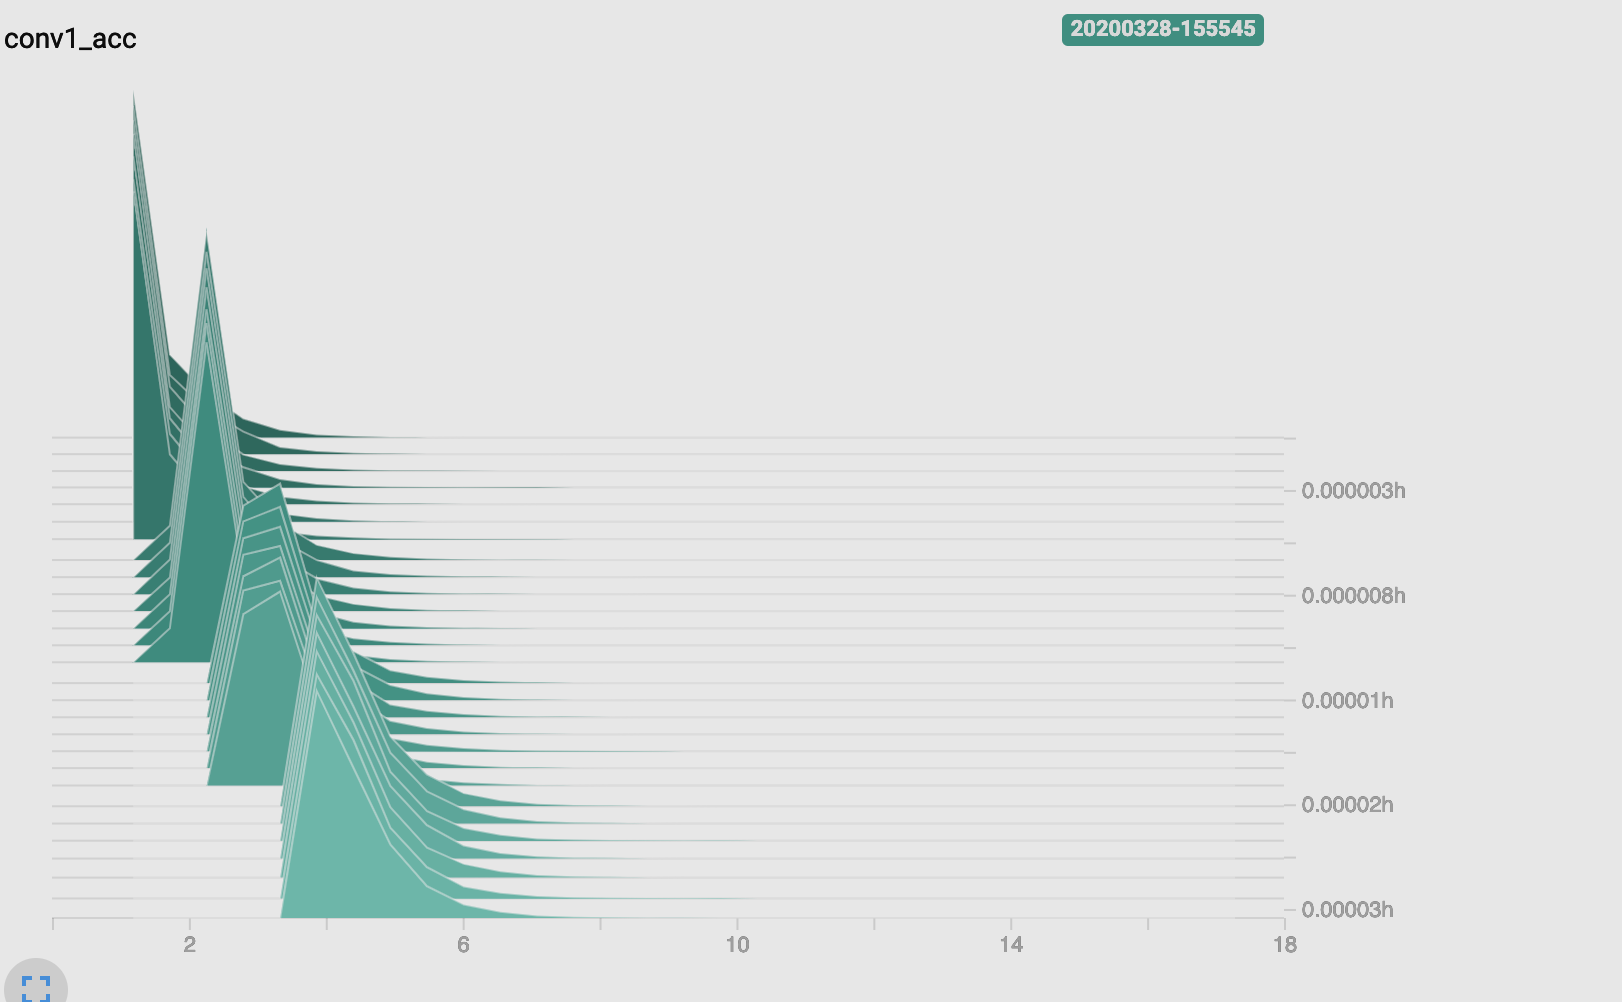

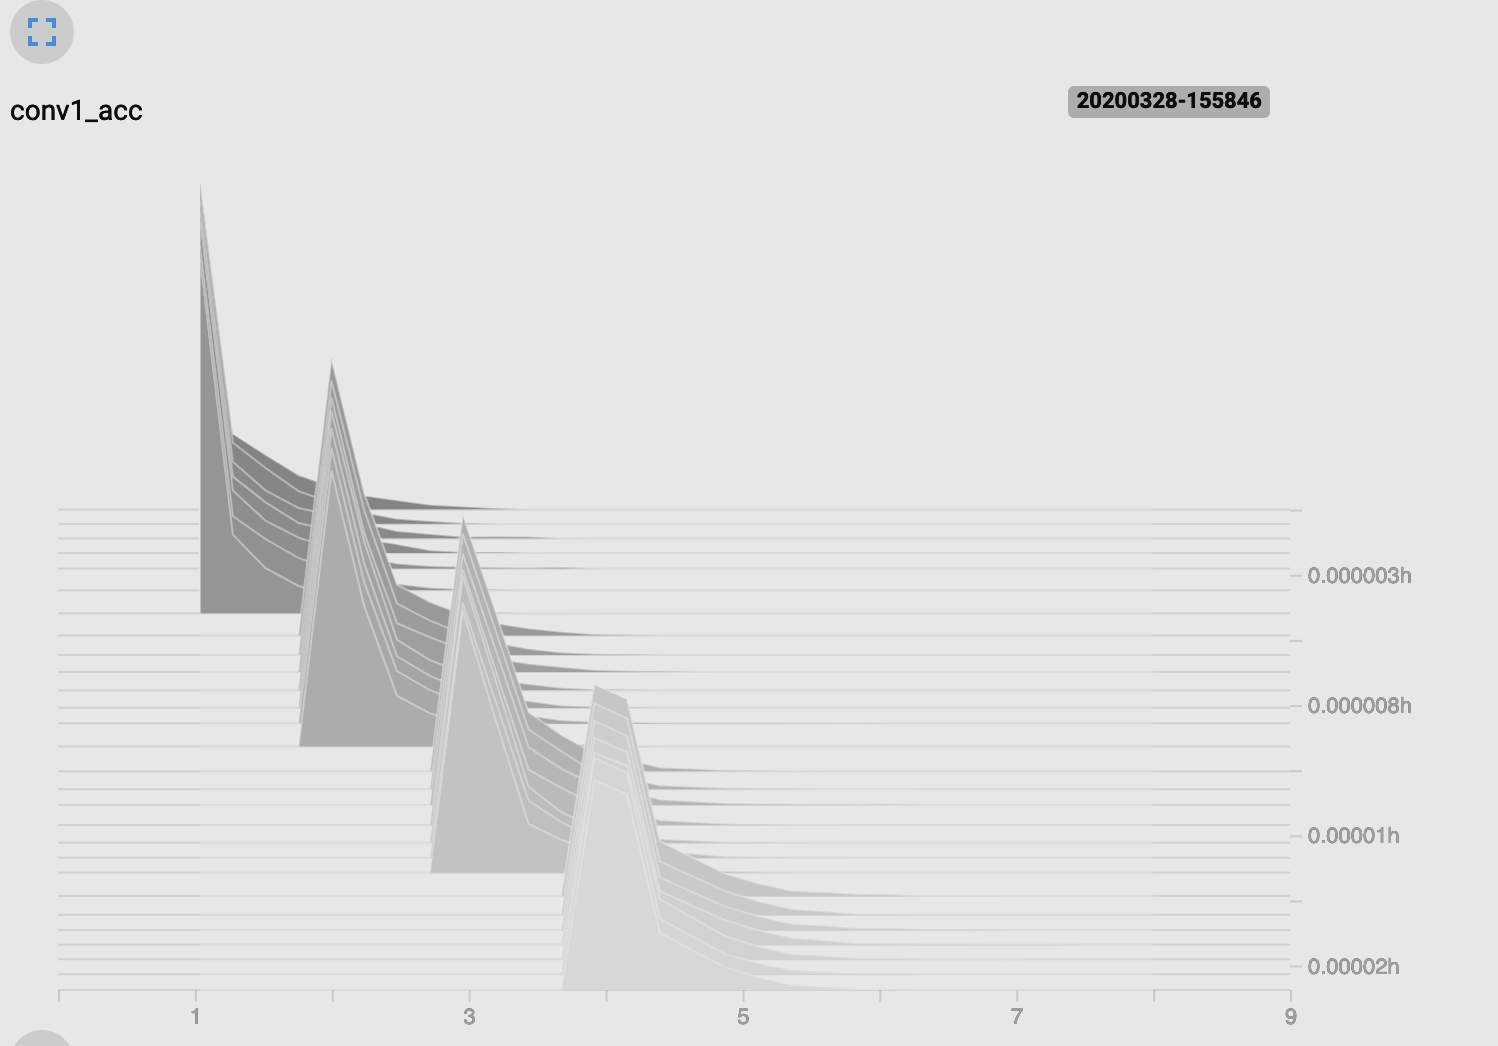

Seems like with batch norm, first layer learns faster.

In addition, with Batch Norm, the final learned activations look more centered.

Second layer activations:

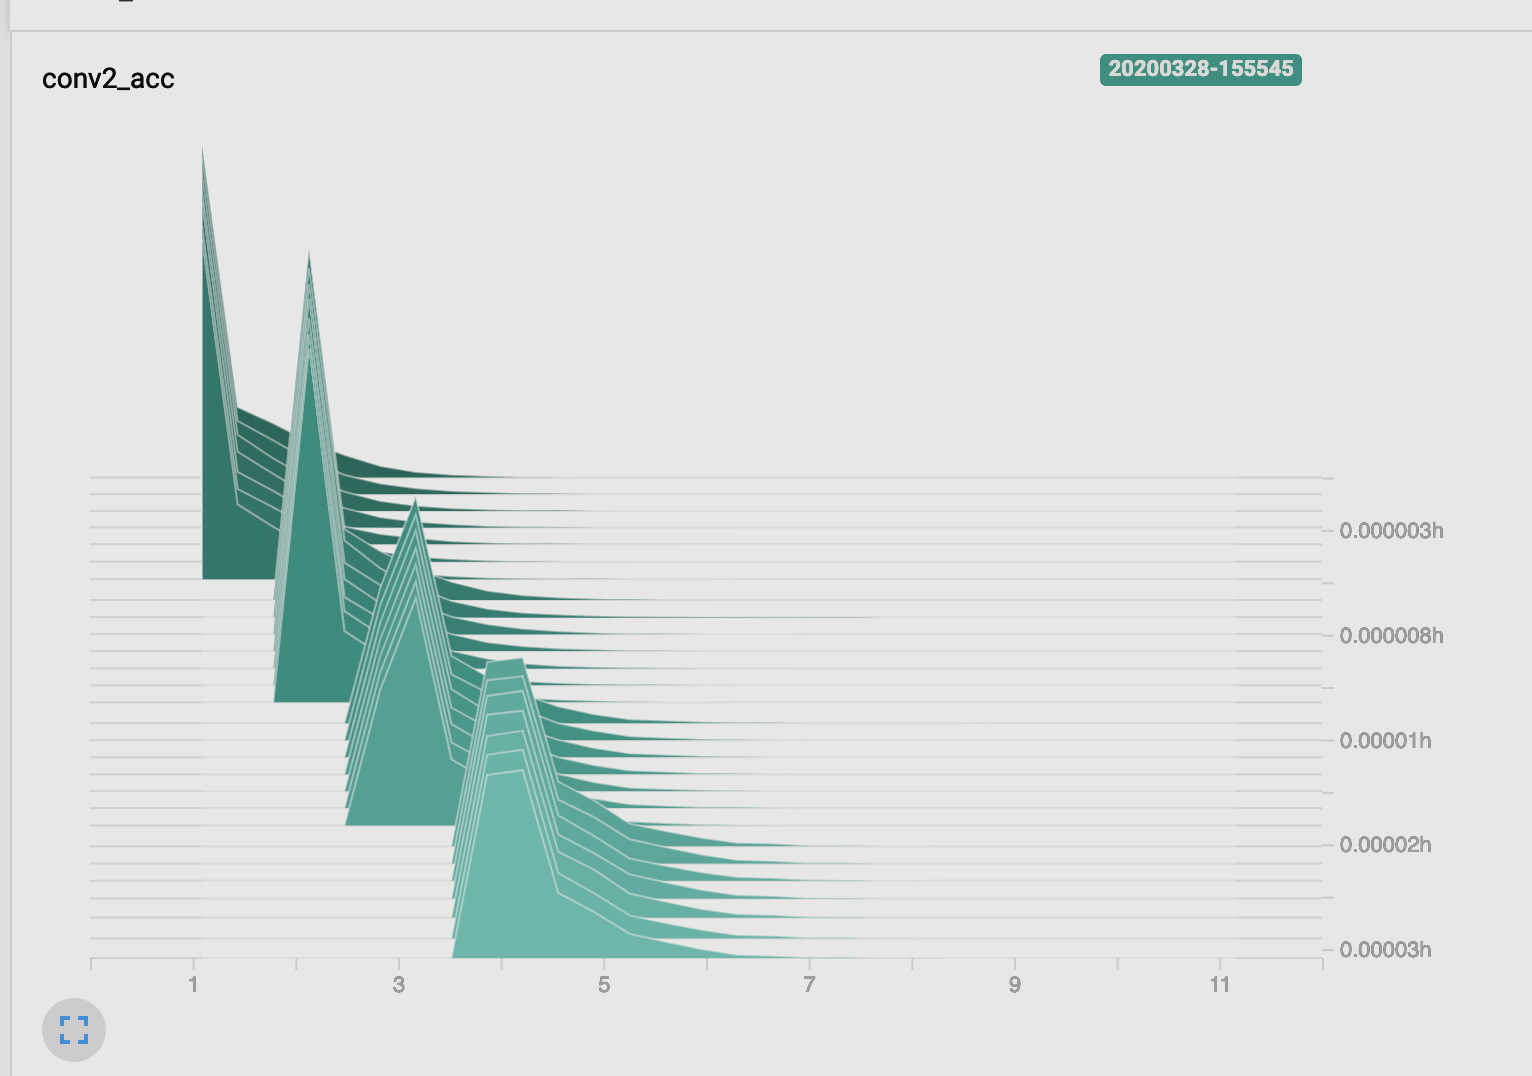

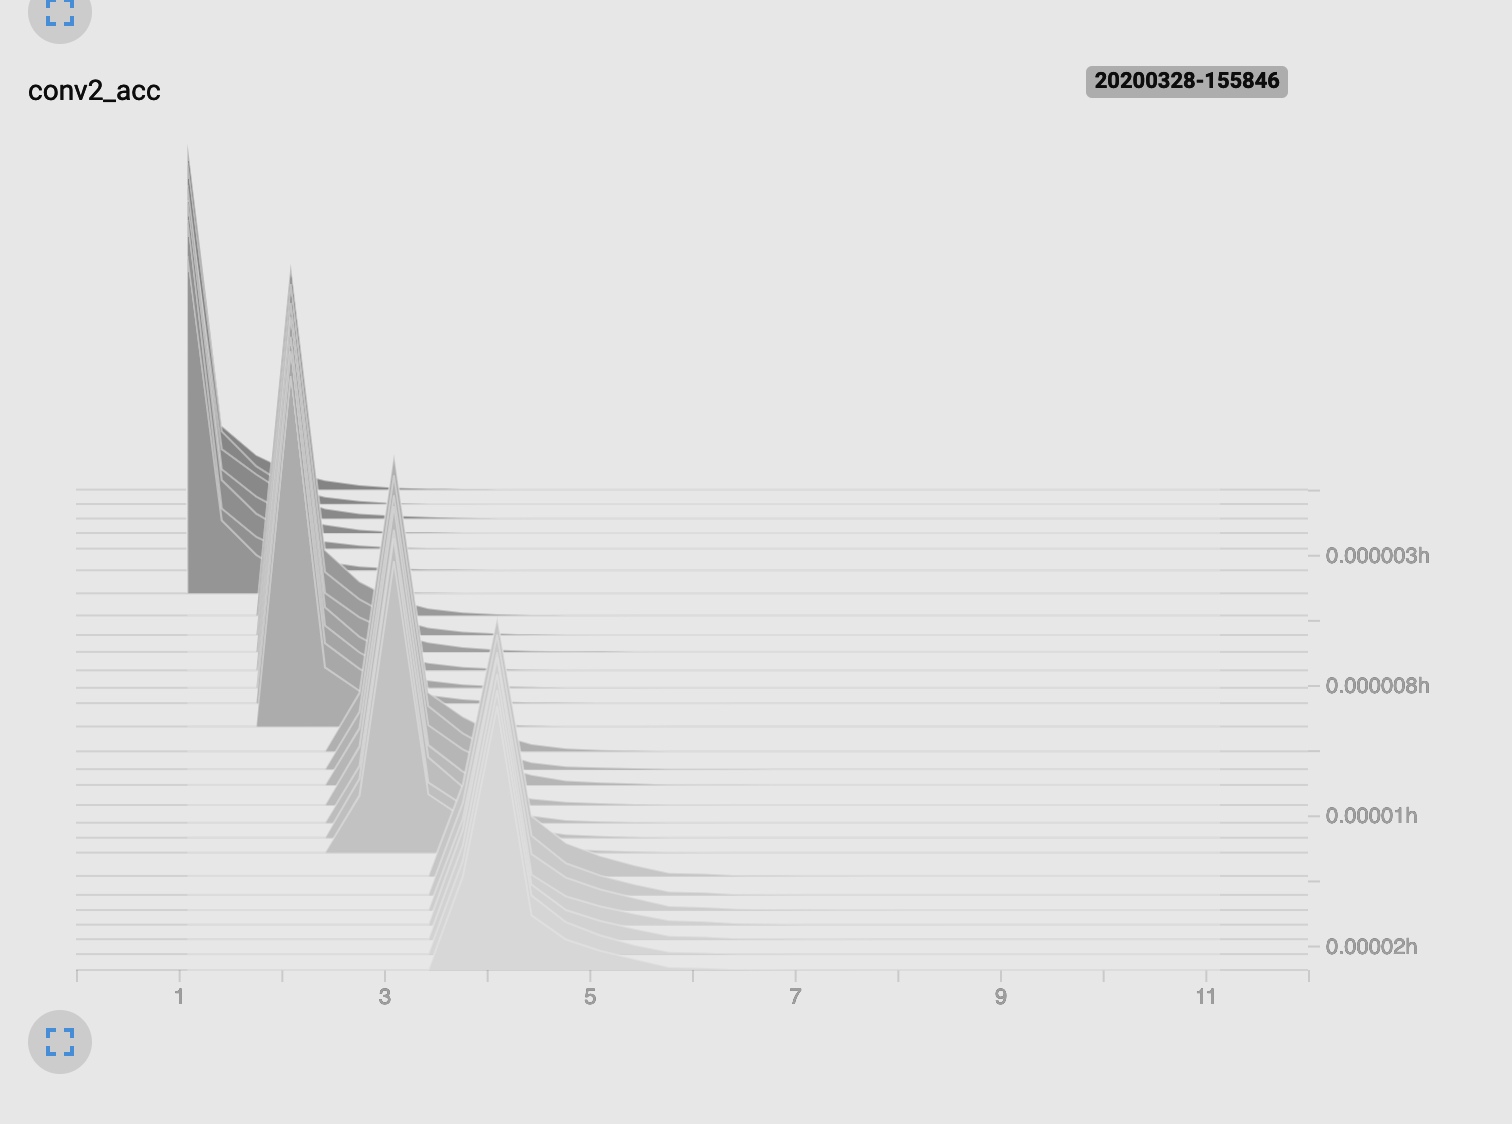

We see faster learning with batch norm in the second layer as well.

Interestingly, here seems like batch norm is causing a wider distribution, meaning activations are more ambiguous.

Compare activations in the FC layer:

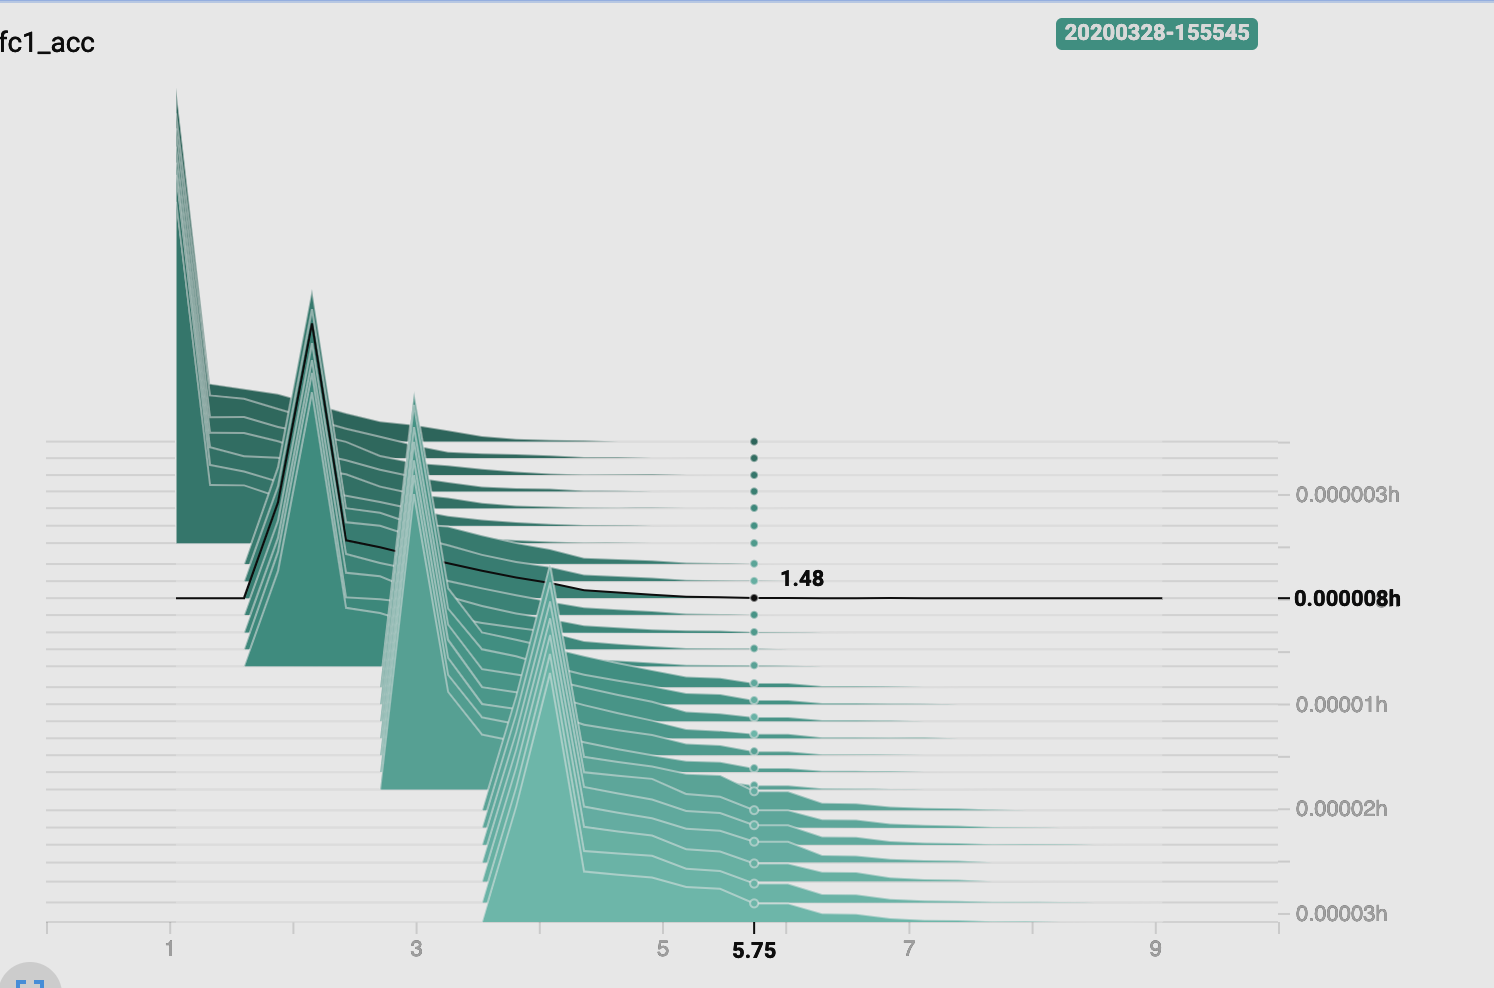

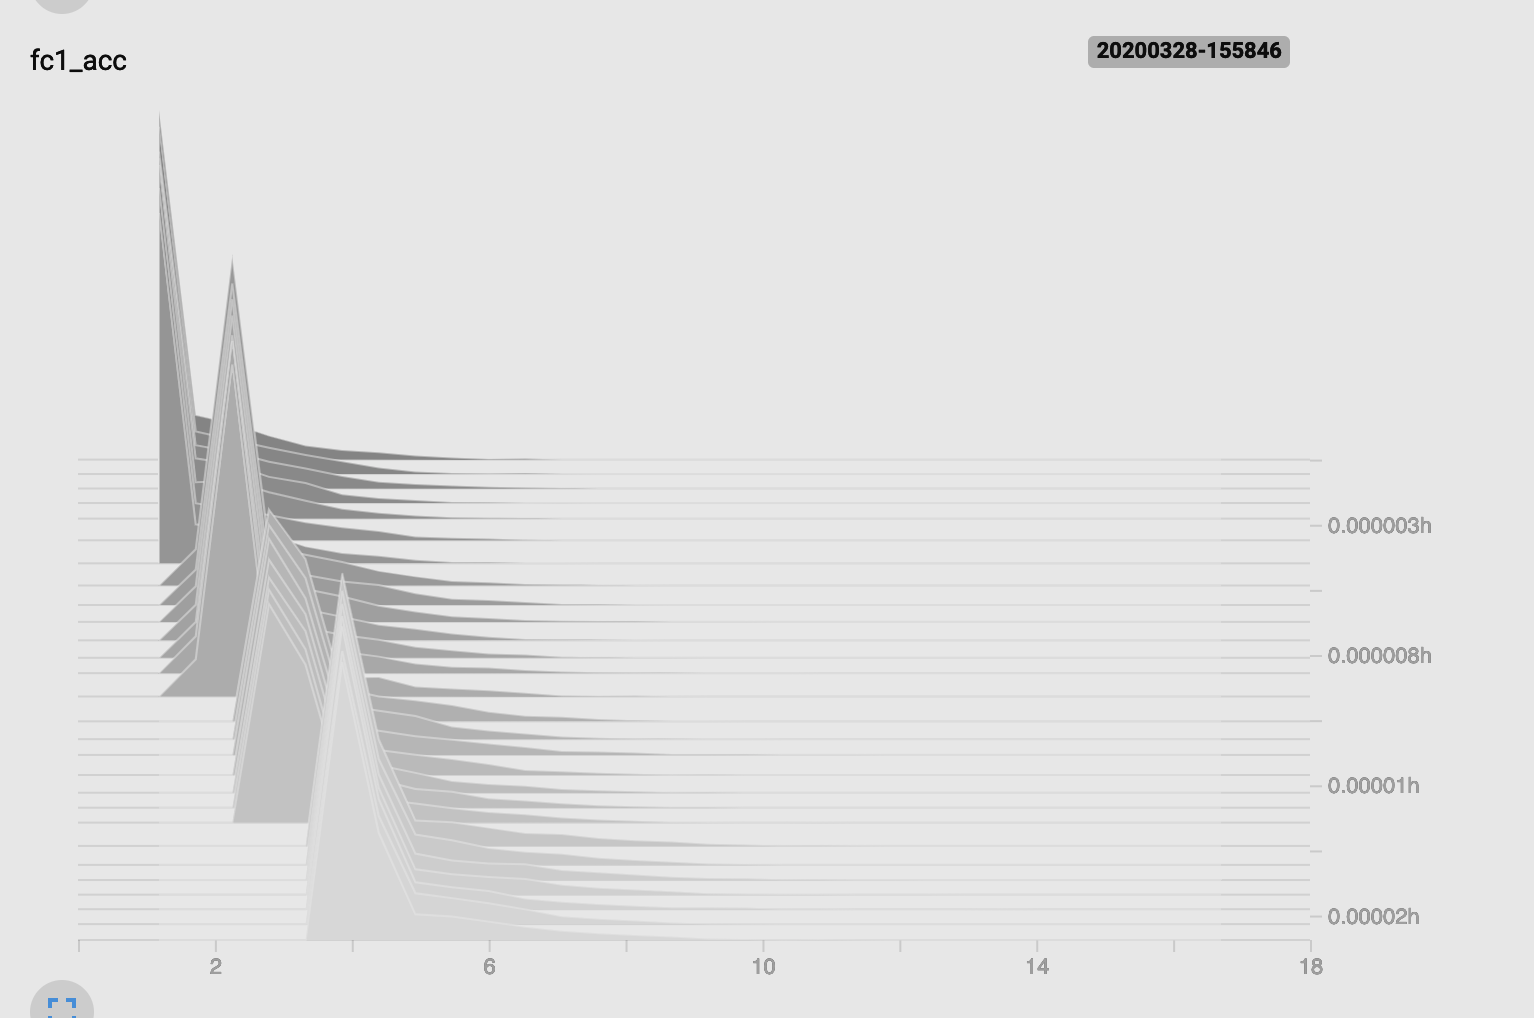

Here we see that with batch norm there is more information in the tail of the distribution, which could indicate better generalisation and less overfitting

## Data Augmentation
Augmenting the data is a useful trick to increase the size of the training set and reduce the generalization error.  

Useful resources: 
- [Explanation about augmentation](https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/)
- The [torchvision transforms documentation](https://pytorch.org/docs/stable/torchvision/transforms.html)
- The [albumentations](https://github.com/albumentations-team/albumentations) repo

Try to think which transformation can be useful for data augmentation for our task?

In [227]:
transform_aug = transforms.Compose(
    [
#     transforms.RandomResizedCrop(32, scale=(0.7, 1.0)),
    transforms.RandomRotation(degrees=(15, -15)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomErasing()
    
    ])

# hymenoptera_dataset = datasets.ImageFolder(root='hymenoptera_data/train',
#                                            transform=data_transform
trainset_aug = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_aug)

trainloader_aug = torch.utils.data.DataLoader(trainset_aug, batch_size=32,
                                          shuffle=True, num_workers=2)

transform_resize = transforms.Compose(
    [
#         transforms.RandomCrop(28),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


testset_resized = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_resize)
testloader_resized = torch.utils.data.DataLoader(testset_resized, batch_size=32,
                                         shuffle=False, num_workers=2)



# for s in trainloader_aug:
#     print(s[0].shape)
#     break
# for s in testloader_resized:
#     print(s[0].shape)
#     break
netNoBN = NetBN(create_writer=True, use_batch_norm=True)
netNoBN.trainWithLoader(trainloader_aug, testloader=testloader_resized, epochs = 333,print_stats_ival=2000)
print('Loss, Accuracy of the network on the train data: {}'.format(netNoBN.evaluate(trainloader)))
print('Loss, Accuracy of the network on the test data: {}'.format(netNoBN.evaluate(testloader_resized)))

Files already downloaded and verified
Files already downloaded and verified
[1,     0] loss: 2.451
[1] test loss, accuracy: 1.2782559330090166, 0.5388
[2,     0] loss: 1.072
[2] test loss, accuracy: 1.1498754732905867, 0.5859
[3,     0] loss: 1.493
[3] test loss, accuracy: 1.1305864876070724, 0.5907
[4,     0] loss: 1.448
[4] test loss, accuracy: 1.1034558442073128, 0.6087
[5,     0] loss: 1.338
[5] test loss, accuracy: 1.0620969328255698, 0.6267
[6,     0] loss: 0.998
[6] test loss, accuracy: 1.081989537412747, 0.6195
[7,     0] loss: 1.064
[7] test loss, accuracy: 1.076242287890218, 0.626
[8,     0] loss: 1.258
[8] test loss, accuracy: 1.061998697705924, 0.6219
[9,     0] loss: 1.034
[9] test loss, accuracy: 0.9892082420020057, 0.6511
[10,     0] loss: 0.943
[10] test loss, accuracy: 0.9855721451984808, 0.6522
[11,     0] loss: 1.412
[11] test loss, accuracy: 0.9851347722184544, 0.6524
[12,     0] loss: 0.787
[12] test loss, accuracy: 0.9723874736136903, 0.6582
[13,     0] loss: 1.18

[107,     0] loss: 0.769
[107] test loss, accuracy: 0.8117181007473614, 0.7206
[108,     0] loss: 1.108
[108] test loss, accuracy: 0.7989511796460745, 0.7244
[109,     0] loss: 0.633
[109] test loss, accuracy: 0.7966019177970033, 0.7198
[110,     0] loss: 0.801
[110] test loss, accuracy: 0.7953596733058222, 0.7234
[111,     0] loss: 0.765
[111] test loss, accuracy: 0.808363238653055, 0.7187
[112,     0] loss: 0.534
[112] test loss, accuracy: 0.8162787281476651, 0.7161
[113,     0] loss: 1.154
[113] test loss, accuracy: 0.7948145590270289, 0.7229
[114,     0] loss: 0.636
[114] test loss, accuracy: 0.7913604075916278, 0.7233
[115,     0] loss: 0.681
[115] test loss, accuracy: 0.7894606237975172, 0.7266
[116,     0] loss: 0.994
[116] test loss, accuracy: 0.789401551405081, 0.7267
[117,     0] loss: 0.739
[117] test loss, accuracy: 0.8075708763096661, 0.7204
[118,     0] loss: 1.098
[118] test loss, accuracy: 0.7972621923437515, 0.7232
[119,     0] loss: 1.028
[119] test loss, accuracy: 0.

[211,     0] loss: 1.051
[211] test loss, accuracy: 0.7838215798425218, 0.7293
[212,     0] loss: 1.061
[212] test loss, accuracy: 0.7837100586952112, 0.7267
[213,     0] loss: 0.724
[213] test loss, accuracy: 0.7794526073688897, 0.7257
[214,     0] loss: 0.942
[214] test loss, accuracy: 0.7609655084891822, 0.7331
[215,     0] loss: 0.735
[215] test loss, accuracy: 0.7609646775471136, 0.7325
[216,     0] loss: 0.950
[216] test loss, accuracy: 0.77530246192274, 0.7289
[217,     0] loss: 0.690
[217] test loss, accuracy: 0.7692008867812233, 0.7307
[218,     0] loss: 0.800
[218] test loss, accuracy: 0.7691999962345099, 0.7328
[219,     0] loss: 0.764
[219] test loss, accuracy: 0.7771115540125119, 0.7292
[220,     0] loss: 0.853
[220] test loss, accuracy: 0.773336837181268, 0.7296
[221,     0] loss: 0.622
[221] test loss, accuracy: 0.7801532125511108, 0.7245
[222,     0] loss: 1.247
[222] test loss, accuracy: 0.7764378937479025, 0.7289
[223,     0] loss: 0.690
[223] test loss, accuracy: 0.7

[315,     0] loss: 0.698
[315] test loss, accuracy: 0.7640099499743587, 0.7325
[316,     0] loss: 0.713
[316] test loss, accuracy: 0.7600601557344674, 0.7337
[317,     0] loss: 1.189
[317] test loss, accuracy: 0.7614625898984294, 0.7367
[318,     0] loss: 1.228
[318] test loss, accuracy: 0.7660332417335755, 0.7328
[319,     0] loss: 0.788
[319] test loss, accuracy: 0.7683691798498075, 0.7308
[320,     0] loss: 1.284
[320] test loss, accuracy: 0.7528536499689181, 0.7361
[321,     0] loss: 0.718
[321] test loss, accuracy: 0.7639482544062618, 0.7357
[322,     0] loss: 0.625
[322] test loss, accuracy: 0.7651483009988889, 0.7369
[323,     0] loss: 0.665
[323] test loss, accuracy: 0.7650459830562908, 0.7345
[324,     0] loss: 0.634
[324] test loss, accuracy: 0.7500577727064919, 0.742
[325,     0] loss: 0.799
[325] test loss, accuracy: 0.7597842648768196, 0.7357
[326,     0] loss: 0.903
[326] test loss, accuracy: 0.7581936635148411, 0.7363
[327,     0] loss: 0.902
[327] test loss, accuracy: 0

Apply 1 or 2 basic transformations and check how they affect the network's performance:

We applied random rotation (-15 to 15 degrees), random horizontal flip, and random erasing.


Since the data is heavily augmented, we trained for 333 epochs and got a significant improvement: 0.739 accuracy which is 0.0746 improvement on our best result so far.

## Transfer learning using a NN pre-trained on ImageNet
In this section, we will use a pretrained network and build a classifier using it to predict the labels of our task.

You might find these resources useful:
- https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
- https://towardsdatascience.com/transfer-learning-with-convolutional-neural-networks-in-pytorch-dd09190245ce
- https://www.analyticsvidhya.com/blog/2019/10/how-to-master-transfer-learning-using-pytorch/
- https://heartbeat.fritz.ai/transfer-learning-with-pytorch-cfcb69016c72

### Use a frozen pre-trained network
Use a VGG-16 network, including its weights pretrained on ImageNet.  
Use the pretrained network to obtain the distributed representation in the final layer (the one before the output softmax layer). Freeze the network weights, and add 2 fully connected layers on top of it to classify the images.

In [3]:
from torchvision import models
model = models.vgg16(pretrained=True)

In [14]:
model.classifier
for param in model.parameters():
    param.requires_grad = False

<bound method Module.parameters of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size

In [28]:
model.classifier[6] = torch.nn.Sequential(
                      torch.nn.Linear(4096, 256), 
                      torch.nn.ReLU(), 
                      torch.nn.Dropout(0.4),
                      torch.nn.Linear(256, 10))
model.classifier


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [29]:

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
n_epochs = 3

for epoch in range(n_epochs):
    for i, data in enumerate(trainloader, 0):
        optimizer.zero_grad()
        X, y_true = data
        # Generate predictions
        y_pred = model(X)
        # Calculate loss
        loss = criterion(y_pred, y_true)
        # Backpropagation
        loss.backward()
        # Update model parameters
        optimizer.step()
        if i % 200 == 0 and i != 0:
                    print('[%d, %5d] loss: %.3f' % (epoch + 1, i, loss.item()))

[1,   200] loss: 1.441
[1,   400] loss: 1.351
[1,   600] loss: 1.362
[1,   800] loss: 1.706
[1,  1000] loss: 1.507
[1,  1200] loss: 1.276
[1,  1400] loss: 1.309
[2,   200] loss: 1.317
[2,   400] loss: 1.287
[2,   600] loss: 1.240
[2,   800] loss: 1.295
[2,  1000] loss: 1.454
[2,  1200] loss: 1.168
[2,  1400] loss: 1.118
[3,   200] loss: 1.017
[3,   400] loss: 1.409
[3,   600] loss: 1.149
[3,   800] loss: 0.860
[3,  1000] loss: 1.212
[3,  1200] loss: 1.356
[3,  1400] loss: 1.086


In [50]:
model.eval()
total = 0
correct = 0
with torch.no_grad():
    for data, y_true in testloader:
        log_ps = model(data)
        _, y_pred = torch.max(log_ps, dim=1)
        equals = y_pred == y_true
        total += y_true.size(0)
        correct += equals.sum().item()
    
print(correct / total)

0.6054


### Fine tuning the weights
In this section, we'll unfreeze the pre-trained weights of the network and allow them to change.  
Be careful - when fine-tuning a network, there is a risk that our attempt to allow the network to adapt to the new domain will lead to a "catastrophic forgetting" of what it had previously learnt.

In [65]:
model_unfrozen = models.vgg16(pretrained=True)

In [66]:

# for param in model.parameters():
#     print(param)
i = 0
for param in model_unfrozen.parameters():
    i += 1
    if (i % 3) == 0:
        param.requires_grad = False
    print(param.requires_grad)

model_unfrozen.classifier[6] = torch.nn.Sequential(
                      torch.nn.Linear(4096, 256), 
                      torch.nn.ReLU(), 
                      torch.nn.Dropout(0.4),
                      torch.nn.Linear(256, 10))

criterion_unfrozen = torch.nn.CrossEntropyLoss()
optimizer_unfrozen = torch.optim.Adam(model_unfrozen.parameters())
n_epochs = 3

for epoch in range(n_epochs):
    for i, data in enumerate(trainloader, 0):
        optimizer_unfrozen.zero_grad()
        X, y_true = data
        # Generate predictions
        y_pred = model_unfrozen(X)
        # Calculate loss
        loss = criterion_unfrozen(y_pred, y_true)
        # Backpropagation
        loss.backward()
        # Update model parameters
        optimizer_unfrozen.step()
        if i % 200 == 0 and i != 0:
                    print('[%d, %5d] loss: %.3f' % (epoch + 1, i, loss.item()))

True
True
False
True
True
False
True
True
False
True
True
False
True
True
False
True
True
False
True
True
False
True
True
False
True
True
False
True
True
False
True
True
[1,   200] loss: 1.807
[1,   400] loss: 1.790
[1,   600] loss: 1.774
[1,   800] loss: 1.700
[1,  1000] loss: 1.381
[1,  1200] loss: 1.712
[1,  1400] loss: 1.231
[2,   200] loss: 1.181
[2,   400] loss: 1.126
[2,   600] loss: 1.120
[2,   800] loss: 1.357
[2,  1000] loss: 1.034
[2,  1200] loss: 0.986
[2,  1400] loss: 0.884
[3,   200] loss: 0.952
[3,   400] loss: 1.050
[3,   600] loss: 1.022
[3,   800] loss: 0.743
[3,  1000] loss: 1.311
[3,  1200] loss: 1.388
[3,  1400] loss: 0.699


In [67]:
model_unfrozen.eval()
total = 0
correct = 0
with torch.no_grad():
    for data, y_true in testloader:
        log_ps = model_unfrozen(data)
        _, y_pred = torch.max(log_ps, dim=1)
        equals = y_pred == y_true
        total += y_true.size(0)
        correct += equals.sum().item()
    
print(correct / total)

0.7181


## Suggested Resources
1. A good explanation of the different losses - https://gombru.github.io/2019/04/03/ranking_loss/
1. A repo with code implementing CNN classifiers, Siamese networks and Triplet loss with different selection regimes for the MNIST and Fashion-MNIST datasets - https://github.com/adambielski/siamese-triplet
1. There are several resources online for the VGG-Face network (see https://www.robots.ox.ac.uk/~vgg/publications/2015/Parkhi15/parkhi15.pdf), that include pre-trained weights on a face recognition dataset. The weights are here - http://www.robots.ox.ac.uk/~vgg/software/vgg_face/, and PyTorch models are here - http://www.robots.ox.ac.uk/~albanie/pytorch-models.html, and you can also check out https://github.com/prlz77/vgg-face.pytorch and https://github.com/claudio-unipv/vggface-pytorch.